In [1]:
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import tqdm
import time
import os
import wandb
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from collections import OrderedDict
from external_utils import format_time
from utils.data_preprocessing import preprocess_dataset_get_dataset, generate_dataset_from_loader,preprocess_dataset_get_data_loader,get_data_loader
from structure.dlgn_conv_config_structure import DatasetConfig
import numpy as np
import csv
from conv4_models import get_model_instance_from_dataset, get_img_size
from utils.forward_visualization_helpers import merge_operations_in_modules, apply_input_on_conv_matrix, merge_layers_operations_in_modules
from sklearn import datasets, metrics, svm
from tqdm import trange
import pickle
from structure.generic_structure import SaveFeatures
from matplotlib import colors
from sklearn.decomposition import PCA
from adversarial_attacks_tester import apply_adversarial_attack_on_input

Using TensorFlow backend.
2024-10-02 02:05:57.474723: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2024-10-02 02:05:57.474906: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2024-10-02 02:05:57.474919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2024-10-02 02:05:58.538393: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-02 02:05:58.618656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with propertie

In [2]:
!pip install shap

In [3]:
import shap

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model_arch_type = 'dnn'
dataset = 'fashion_mnist'
data_config = DatasetConfig(
                dataset, is_normalize_data=True, valid_split_size=0.1, batch_size=8, list_of_classes=None,custom_dataset_path=None)

filtered_X_train, filtered_y_train, _, _, filtered_X_test, filtered_y_test = preprocess_dataset_get_dataset(
            data_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)
print("filtered_X_train ",np.max(filtered_X_train),np.min(filtered_X_train))
print("filtered_X_test ",np.max(filtered_X_test),np.min(filtered_X_test))
trainloader = get_data_loader(
    filtered_X_train, filtered_y_train, data_config.batch_size, transforms=data_config.train_transforms)
testloader = get_data_loader(
    filtered_X_test, filtered_y_test, data_config.batch_size, transforms=data_config.test_transforms)

# trainloader, _, testloader = preprocess_dataset_get_data_loader(
#                 data_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

np.max(filtered_X_train) 255.0
filtered_X_train  1.0 0.0
filtered_X_test  1.0 0.0


In [62]:
class Loss_Wrapper_Module(nn.Module):
    def __init__(self, actual_model):
        super(Loss_Wrapper_Module, self).__init__()
        self.actual_model = actual_model
    
    def forward(self, gating_signals=None,inp=None):
        if(type(gating_signals)!=list):
            gating_signals = torch.split(gating_signals,gating_signals.size()[-1]//len(self.actual_model.list_of_modules),-1)
        if(inp is None):
            inp = torch.ones(gating_signals[0].shape[0],1,self.actual_model.input_size).to(device=gating_signals[0].device)
        
        outputs = self.actual_model(inp,gating_signals)
        # print(outputs.size())
        return outputs

In [63]:
def get_shapely_values(model_arch_type,mpath,trainloader,fc_width=128,fc_depth = 4,pca_exp_percent=None):
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model = get_model_instance_from_dataset(dataset,model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    model.load_state_dict(torch.load(mpath).state_dict())
    model = model.to(device)
    model.eval()

    # Define the loss function (CrossEntropyLoss)
    criterion = nn.CrossEntropyLoss()

    sample_data, sample_labels = tst = next(iter(trainloader))
    sample_data = sample_data.to(device)
    sample_labels = sample_labels.to(device)
    print("sample_data ",sample_data.size())

    inp_gating = torch.ones(sample_data.size(),requires_grad=True, device=device)

    linear_conv_outputs, _ = model.gating_network(sample_data)

    feature_map = [None] * len(linear_conv_outputs)
    for indx in range(len(linear_conv_outputs)):
        each_linear_conv_output = linear_conv_outputs[indx]
        feature_map[indx] = nn.Sigmoid()(
            model.beta * each_linear_conv_output)
    feature_map = torch.cat(feature_map,dim=-1)
    print("feature_map ",feature_map.size())

    valnet = Loss_Wrapper_Module(model.value_network)
    output = valnet(feature_map,inp_gating)

    explainer = shap.DeepExplainer(valnet, feature_map)
    shap_values = explainer.shap_values(feature_map)
    
    return shap_values,feature_map.detach().cpu().numpy()

In [64]:
pgdat_path = "root/model/save/fashion_mnist/adversarial_training/MT_fc_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/OPT_Adam (Parameter Group 0    amsgrad: False    betas: (0.9, 0.999)    eps: 1e-08    lr: 0.0001    weight_decay: 0)/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/out_lossfn_CrossEntropyLoss()/inner_lossfn_CrossEntropyLoss()/adv_model_dir.pt"
shap_values,fm = get_shapely_values("fc_dlgn",pgdat_path,trainloader)

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 150016
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306


sample_data  torch.Size([8, 1, 28, 28])
feature_map  torch.Size([8, 512])


In [72]:
len(shap_values),[i.shape for i in shap_values],fm.shape

(10,
 [(8, 512),
  (8, 512),
  (8, 512),
  (8, 512),
  (8, 512),
  (8, 512),
  (8, 512),
  (8, 512),
  (8, 512),
  (8, 512)],
 (8, 512))

In [74]:
shap_values[0][0].reshape(128,4).shape, fm[0].reshape(128,4).shape

((128, 4), (128, 4))

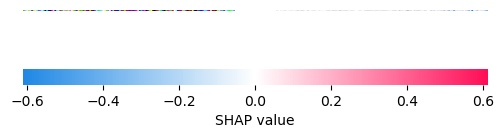

In [75]:
shap.image_plot(shap_values[0][0].reshape(1,128,4), fm[0].reshape(1,128,4))